# Transfer Learning using Keras and EfficientNet

In this notebook, we will train a classifier on the fashion MNIST dataset, but rather than building and training a CNN model from scratch, we'll use Google's EfficientNet model pre-trained on the ImageNet dataset as a base. Essentially, this will transfer the knowledge accumulated during the training on a large image dataset with 1000 classes to a similar, more specific problem – classifying fashion apparel.

## Getting the dependencies

Let's first get the `efficientnet` package that includes the model architecture.

In [1]:
!pip install efficientnet==1.1.0

     |████████████████████████████████| 50 kB 4.2 MB/s eta 0:00:011


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
# import the tensorflow.keras version of efficientnet
from efficientnet import tfkeras as efficientnet

from utils import cifar100_fine_labels

## GPU support

If you want to train a deep network fast, you have to use dedicated hardware, like GPU.
On **Google Colab**, you can enable the GPU in the following way:

- navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll check if we can connect to the GPU:

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    # the ANSI escape codes are just for colour 
    print('\033[91m', 'GPU device not found', '\033[0m')
else:
    print('\033[92m', 'Found GPU at: {}\033[0m'.format(device_name), '\033[0m')

 GPU device not found 


## Loading data

We'll use the Fashion MNIST dataset mainly because it comes together with Keras as a toy dataset. Feel free to change it to any other dataset (you might need to use [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for loading it). The CIFAR100 dataset has 100 classes, so for debugging purposes, it's convenient to know the labels as well.

**Hint:** if the command below fails because of `500 Internal server error`, try to rerun it a couple of times.

In [6]:
cifar100_data = keras.datasets.cifar100.load_data(label_mode="fine")

169009152/169001437 [==============================] - 12s 0us/step


In [7]:
(x_train, y_train), (x_val, y_val) = cifar100_data

It's a good habit to check how data looks like before actually starting to work with it.

Let's display the basic information about data and visualise a couple of images to get a sense of what we're dealing with:

In [8]:
print('Train shapes:', x_train.shape, y_train.shape)
print('Valid shapes:', x_val.shape, y_val.shape)
print(f'X data min: {np.min(x_train)}, max: {np.max(x_train)}')
print(f'X data type: {x_train.dtype}, Y data type: {y_train.dtype}')
print('Number of unique labels:', len(np.unique(y_train)))

Train shapes: (50000, 32, 32, 3) (50000, 1)
Valid shapes: (10000, 32, 32, 3) (10000, 1)
X data min: 0, max: 255
X data type: uint8, Y data type: int64
Number of unique labels: 100


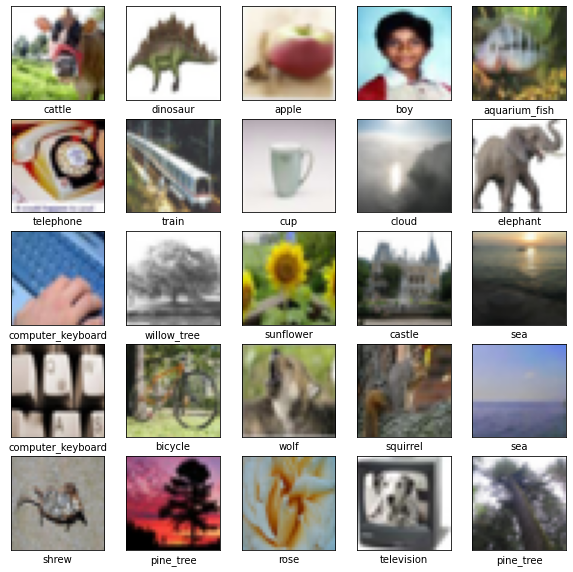

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(cifar100_fine_labels[y_train[i,0]])
plt.show()

As we can see, we have 50 000 images in the training set and 10 000 in the validation set. The images are 32×32×3 (3 stands for the three colours, Red, Green, and Blue) and there are 100 classes.

In [10]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=efficientnet.preprocess_input
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=efficientnet.preprocess_input
)


y_train = keras.utils.to_categorical(y_train, 100)
y_val = keras.utils.to_categorical(y_val, 100)

In [11]:
def get_model():
    base_model = efficientnet.EfficientNetB0(
        weights='noisy-student',
        pooling='avg',
        include_top=False,
        input_shape=(32, 32, 3))
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    predictions = keras.layers.Dense(100, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [12]:
model = get_model()

16703488/16696600 [==============================] - 2s 0us/step


In [ ]:
model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.fit(train_datagen.flow(x_val, y_val, batch_size=32), epochs=40, verbose=1)